In [1]:
from differentiable_t1d.uva_padova_jax import square_controls
from differentiable_t1d.dynamics import UvaPadovaParams, UvaPadova, uva_padova
from differentiable_t1d.utils import generate_meals


import jax
import jax.numpy as jnp
import numpy as np
dynamics_params, unused_params, init_state = uva_padova.initialize_patient("adult#001", to_tensors=False)

/home/alex/repos/hybrid_t1d_ode/myvenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading patient adult#001


In [2]:
from differentiable_t1d.controls import BolusParams, BolusController

In [3]:
t0 = jnp.array(0.)
num_days = 3
t1 = 60. * 24 * num_days # 24 hours in minutes
dt = 1.0   # IMPORANT: this can't be too large or else the integration will diverge (ex when t=5.)
T = int((t1 - t0) / dt) + 1

bolus_params = BolusParams(insulin_carb_ratio=unused_params["CR"], correction_factor=unused_params["CF"], target_bg=140., prebolus_time=15.)
basal_rate = unused_params["u2ss"] # u2ss is in pmols/kg/min

meals = generate_meals(bw=dynamics_params.BW.item(), num_days=num_days, seed=0)

eating_rate = 5.0  # g/min
meal_times = meals[:, 0]  # minutes
carb_amounts = meals[:, 1]  # g
meal_dose = carb_amounts # g
# compute meal duration
meal_duration = meal_dose / eating_rate  # minutes
# convert to mg
meal_dose = meal_dose * 1000.0

In [13]:
%%time
from differentiable_t1d.controls import make_sequential_profile, square_profile


def step(t, state, doses):
    bg = UvaPadova.observe_subcutaneous_glucose(dynamics_params, state)
    dose = BolusController.apply(bolus_params, meal_times, carb_amounts, t, dt, bg)
    doses = jnp.concatenate([doses, jnp.array([[t, dose]])], axis=0)

    # meal computations doesn't change so we can compute it outside of the loop
    meal_profile = make_sequential_profile(square_profile, (meal_dose, meal_duration), meal_times)

    insulin_times = doses[:, 0]
    insulin_duration = dt * jnp.ones_like(insulin_times)
    insulin_doses = doses[:, 1]
    # convert U to pmols/kg
    insulin_doses = insulin_doses * 6000 / dynamics_params.BW
    # convert to pmols/kg/min
    insulin_doses = insulin_doses / insulin_duration
    insulin_profile = make_sequential_profile(square_profile, (insulin_doses, insulin_duration), insulin_times)

    # compute meal and insulin rate curves
    carbs = meal_profile(t)
    insulin = insulin_profile(t)
    # add basal dose; more generally, we could instead have another control function for basal dosing
    insulin = insulin + basal_rate * dt
    dstate_dt, _ = UvaPadova.dynamics(dynamics_params, t, state, carbs, insulin)
    state = state + dstate_dt * dt
    return state, dose, doses

def step_wrapped(carry, i):
    state, doses = carry
    t = t0 + i * dt
    state, dose, doses = step(t, state, doses)
    return (state, jax.lax.slice_in_dim(doses, doses.shape[0] - k, doses.shape[0])), (t, dose, state)

k = int(4 * 60. / dt) # jax.jit requires a fixed shape input to avoid recompilation
doses_arr = jnp.zeros((k, 2))

init_carry = (init_state, doses_arr)
timesteps = jnp.arange(1, T)
_, (ts, doses, states) = jax.lax.scan(step_wrapped, init_carry, timesteps)

states = jnp.concatenate([init_state[None, :], states], axis=0)
ts = jnp.concatenate([jnp.array([t0]), ts], axis=0)
doses = jnp.concatenate([jnp.zeros((1,)), doses], axis=0)

CPU times: user 342 ms, sys: 3.91 ms, total: 346 ms
Wall time: 342 ms


In [14]:
q_sto1, q_sto2, q_gut, G_p, G_t, I_p, X, I_1, I_d, I_l, I_sc1, I_sc2, Gs = states.T

[Text(0, 0.5, 'Gs')]

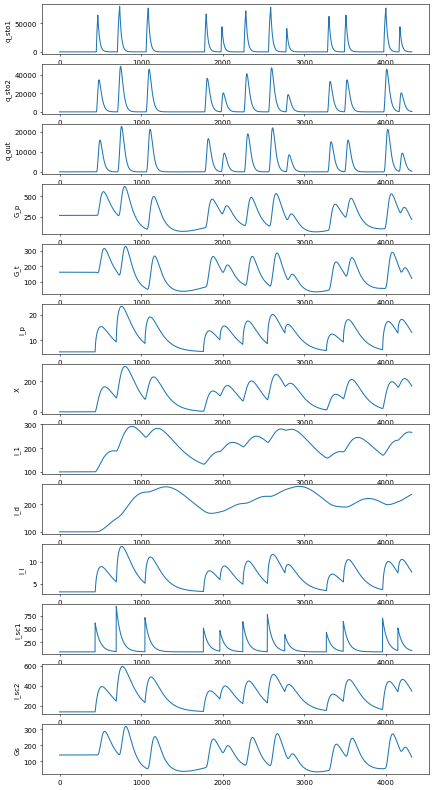

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(13, 1, figsize=(10, 20), dpi=50)
ax[0].plot(q_sto1)
ax[0].set(ylabel="q_sto1")
ax[1].plot(q_sto2)
ax[1].set(ylabel="q_sto2")
ax[2].plot(q_gut)
ax[2].set(ylabel="q_gut")
ax[3].plot(G_p)
ax[3].set(ylabel="G_p")
ax[4].plot(G_t)
ax[4].set(ylabel="G_t")
ax[5].plot(I_p)
ax[5].set(ylabel="I_p")
ax[6].plot(X)
ax[6].set(ylabel="X")
ax[7].plot(I_1)
ax[7].set(ylabel="I_1")
ax[8].plot(I_d)
ax[8].set(ylabel="I_d")
ax[9].plot(I_l)
ax[9].set(ylabel="I_l")
ax[10].plot(I_sc1)
ax[10].set(ylabel="I_sc1")
ax[11].plot(I_sc2)
ax[11].set(ylabel="I_sc2")
ax[12].plot(Gs)
ax[12].set(ylabel="Gs")

In [21]:
nonzero = doses.nonzero()[0]
insulin_doses = doses[nonzero]
insulin_times = ts[nonzero]

[Text(0.5, 0, 'Time (hr)'), Text(0, 0.5, 'Glucose (mg/dL)')]

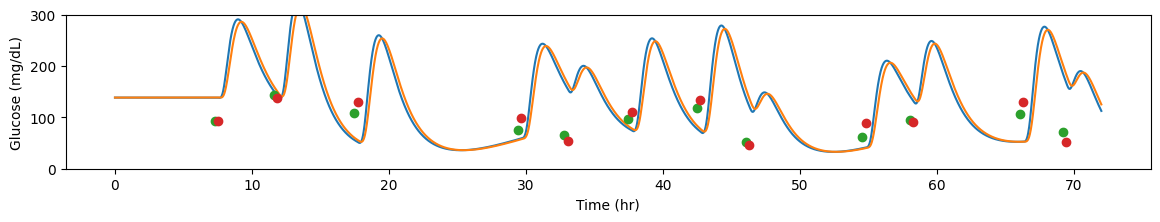

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(14, 2))
t = np.arange(T) * dt
G = UvaPadova.observe_blood_glucose(dynamics_params, states)
Gs = UvaPadova.observe_subcutaneous_glucose(dynamics_params, states)
ax.plot(t / 60, G)
ax.plot(t / 60, Gs)
ax.plot(insulin_times / 60, insulin_doses * 10, 'o')
ax.plot(meal_times / 60, meal_dose * 0.001, 'o')
ax.set(ylim=[0, 300])
ax.set(xlabel="Time (hr)", ylabel="Glucose (mg/dL)")

[(0.0, 300.0)]

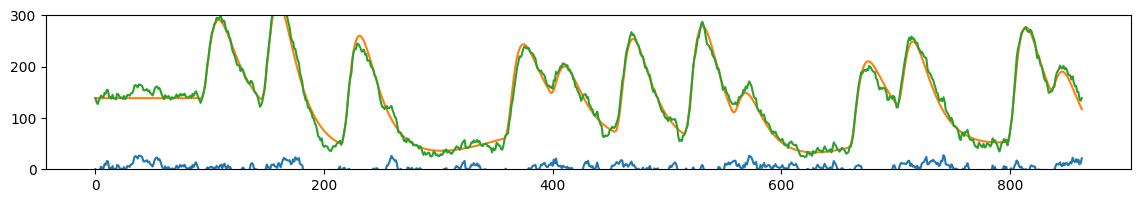

In [37]:
# try adding autoregressive noise similar to what you might get from a CGM
# also subsample to be every 5 mins

noise = jax.random.normal(jax.random.PRNGKey(0), (len(G) // 5,)) * 5 
noise = np.array(noise)
for i in range(1, len(noise)):
    noise[i] = noise[i] + 0.9 * noise[i - 1]

fig, ax = plt.subplots(1, 1, figsize=(14, 2))

noisy_G = np.array(noise.copy())
G_subsampled = np.array(noise.copy())
for i in range(len(noisy_G)):
    noisy_G[i] = noisy_G[i] + G[i * 5]
    G_subsampled[i] = G[i * 5]

ax.plot(noise)
ax.plot(G_subsampled)
ax.plot(noisy_G)
ax.set(ylim=[0, 300])